distance-to-solar-noon         0
temperature                    0
wind-direction                 0
wind-speed                     0
sky-cover                      0
visibility                     0
humidity                       0
average-wind-speed-(period)    1
average-pressure-(period)      0
power-generated                0
dtype: int64
Tuning hyperparameters for Linear Regression...
Best parameters for Linear Regression: {'fit_intercept': True}
Linear Regression - MSE: 39495176.5240, R²: 0.6251, RMSE: 6284.5188

Tuning hyperparameters for Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 10, 'fit_intercept': True}
Lasso Regression - MSE: 39490652.4467, R²: 0.6251, RMSE: 6284.1588

Tuning hyperparameters for Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 10, 'fit_intercept': True}
Ridge Regression - MSE: 39499173.8623, R²: 0.6250, RMSE: 6284.8368

Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 10, 

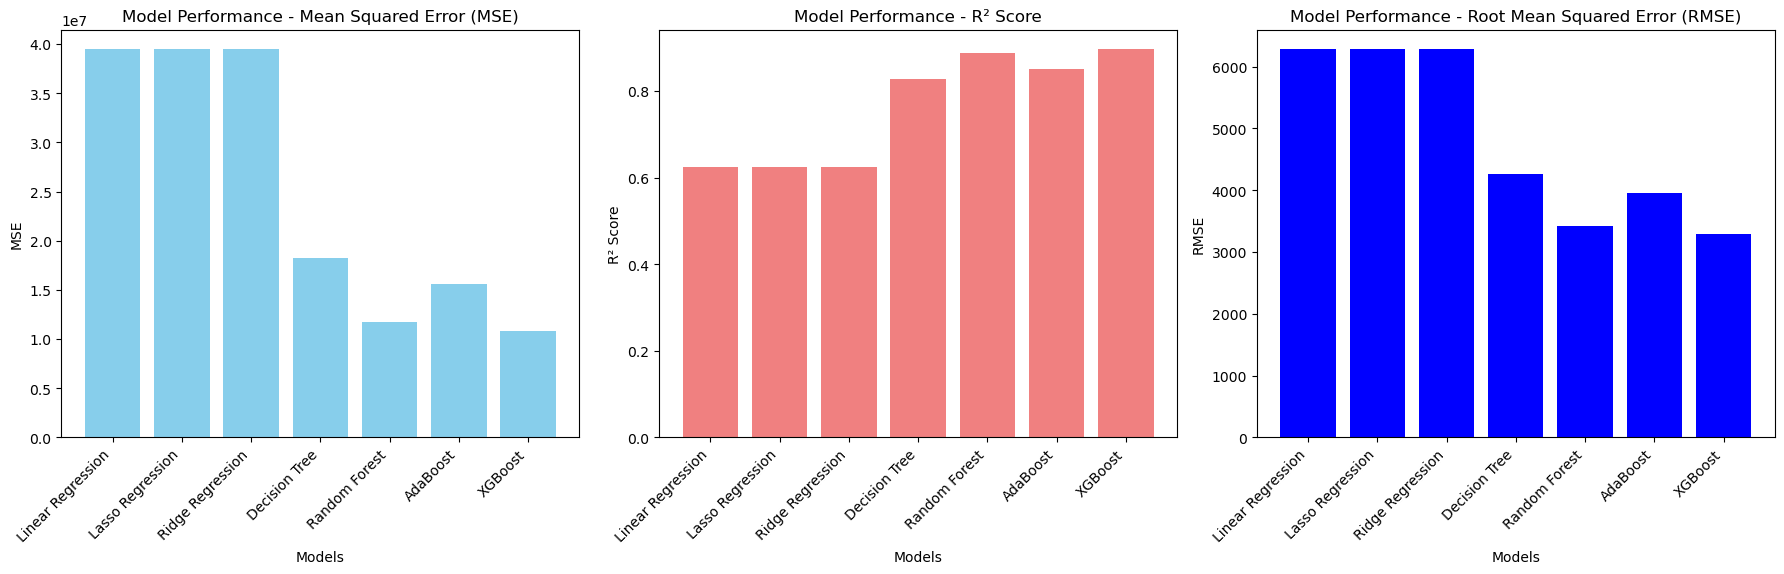

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# Load your solar panel dataset (replace 'solar_data.csv' with your actual dataset file)
data = pd.read_csv(r'C:\Users\itsej\OneDrive\Desktop\PROJECT DATASCIENCE\solarpowergeneration.csv')

# Check for missing values
print(data.isnull().sum())

# Assuming 'power-generated' is the target variable and the rest are features
X = data.drop('power-generated', axis=1)
y = data['power-generated']

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


# Standardize features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids for each model
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
    },
    'Ridge Regression': {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1],
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
    }
}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Dictionary to store best models and their results
best_models = {}
results = {}

# Perform GridSearchCV for each model
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    
    # For Linear, Ridge, and Lasso, use scaled data, for others use raw data
    if model_name in ['Linear Regression', 'Lasso Regression', 'Ridge Regression']:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
    # Store the best model and its results
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    # Make predictions
    if model_name in ['Linear Regression', 'Lasso Regression', 'Ridge Regression']:
        predictions = best_model.predict(X_test_scaled)
    else:
        predictions = best_model.predict(X_test)
    
    # Evaluate model performance
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mse)
    
    # Store results
    results[model_name] = {'MSE': mse, 'R2': r2, 'RMSE': rmse, 'Best Params': grid_search.best_params_}
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}, RMSE: {rmse:.4f}\n")

# Visualize the results using a bar plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extracting values for plotting
model_names = list(results.keys())
mse_values = [metrics['MSE'] for metrics in results.values()]
r2_values = [metrics['R2'] for metrics in results.values()]
rmse_values = [metrics['RMSE'] for metrics in results.values()]

# Create a figure with subplots for MSE,RMSE and R²
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot MSE values
ax[0].bar(model_names, mse_values, color='skyblue')
ax[0].set_title('Model Performance - Mean Squared Error (MSE)')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('MSE')
ax[0].set_xticklabels(model_names, rotation=45, ha='right')

# Plot R² values
ax[1].bar(model_names, r2_values, color='lightcoral')
ax[1].set_title('Model Performance - R² Score')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('R² Score')
ax[1].set_xticklabels(model_names, rotation=45, ha='right')

# Plot RMSE values
ax[2].bar(model_names, rmse_values, color='blue')
ax[2].set_title('Model Performance - Root Mean Squared Error (RMSE)')
ax[2].set_xlabel('Models')
ax[2].set_ylabel('RMSE')
ax[2].set_xticklabels(model_names, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:

Based on the provided plots showing Mean Squared Error (MSE), R² Score, and Root Mean Squared Error (RMSE) for various regression models (Linear Regression, Lasso Regression, Ridge Regression, Decision Tree, Random Forest, AdaBoost, and XGBoost) applied to the solar power generation dataset, here are the insights and observations:

1. Mean Squared Error (MSE) Comparison:
Linear Regression, Lasso Regression, and Ridge Regression have the highest MSE values, approximately 4 x 10⁷, which suggests they do not perform well on this dataset.
Decision Tree shows a significantly lower MSE than linear models, indicating better performance.
Random Forest has the lowest MSE, indicating it performs the best in terms of minimizing the error.
AdaBoost and XGBoost also show relatively low MSE, but XGBoost performs slightly better than AdaBoost.

2. R² Score Comparison:
Random Forest, AdaBoost, and XGBoost have the highest R² scores, all around 0.8 or above, meaning these models explain a high proportion of the variance in the target variable. They are the most accurate models in this set.
Decision Tree follows with an R² score slightly lower than the ensemble methods, still showing decent performance.
Linear, Lasso, and Ridge Regressions show relatively low R² scores (~0.6), indicating that they explain less of the variance compared to decision trees and ensemble methods.

3. Root Mean Squared Error (RMSE) Comparison:
Similar to the MSE plot, Linear, Lasso, and Ridge Regressions show the highest RMSE values, indicating they have larger errors compared to other models.
Random Forest has the lowest RMSE, closely followed by XGBoost, which further confirms that these models perform better.
AdaBoost shows an intermediate RMSE, suggesting it's a strong model but not as robust as Random Forest or XGBoost.

Overall Observations:
    
Linear Models (Linear, Lasso, Ridge Regression) struggle with this dataset, showing poor performance across all metrics (high MSE, high RMSE, and low R²). These models may be underfitting the data due to their simplicity.
Decision Tree performs better than linear models, but still lags behind ensemble methods in terms of overall accuracy.
Random Forest consistently outperforms all other models in terms of MSE, RMSE, and R², suggesting that it captures the data's complexity better.
XGBoost and AdaBoost are also strong contenders, with XGBoost slightly outperforming AdaBoost, especially in terms of MSE and RMSE.

Key Takeaway:
    
Random Forest and XGBoost are the best performing models for this solar energy dataset. They should be prioritized when optimizing for both low error (MSE, RMSE) and high predictive power (R² score).
Linear models should likely be avoided for this specific dataset due to their consistently poor performance across all evaluation metrics.

Linear Regression:
R²: 0.6251
RMSE: 6284.5188



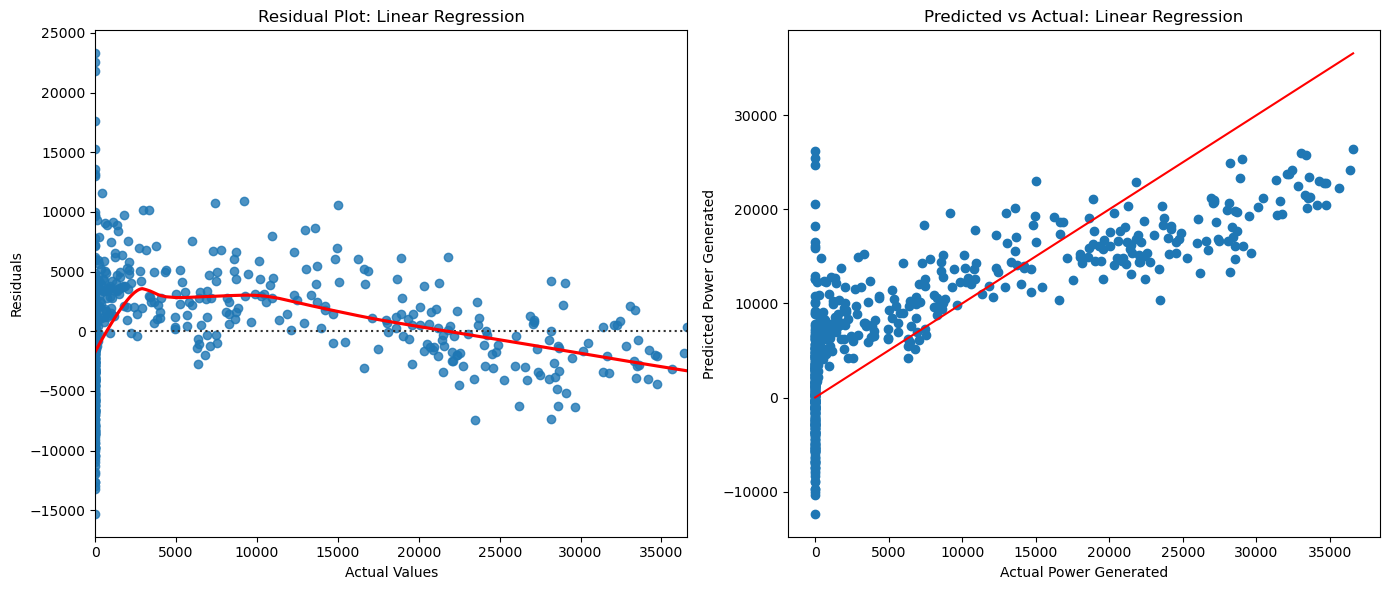

Lasso Regression:
R²: 0.6250
RMSE: 6285.1758



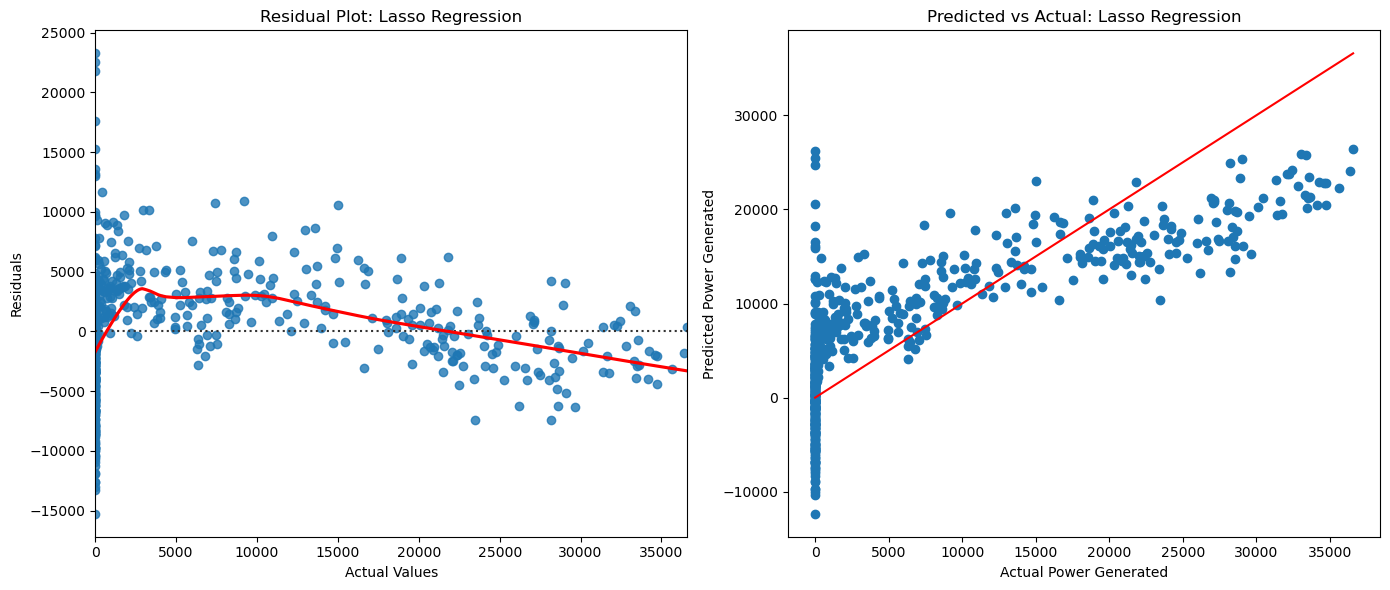

Ridge Regression:
R²: 0.6248
RMSE: 6286.5477



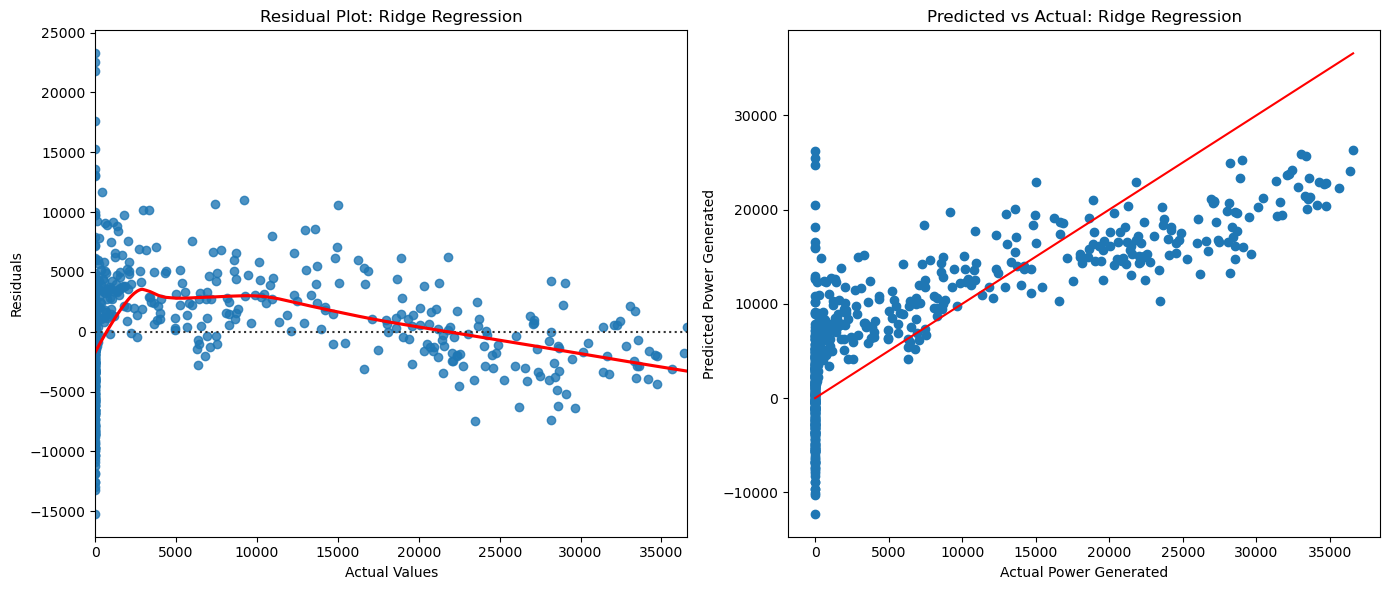

Decision Tree:
R²: 0.8129
RMSE: 4439.8508



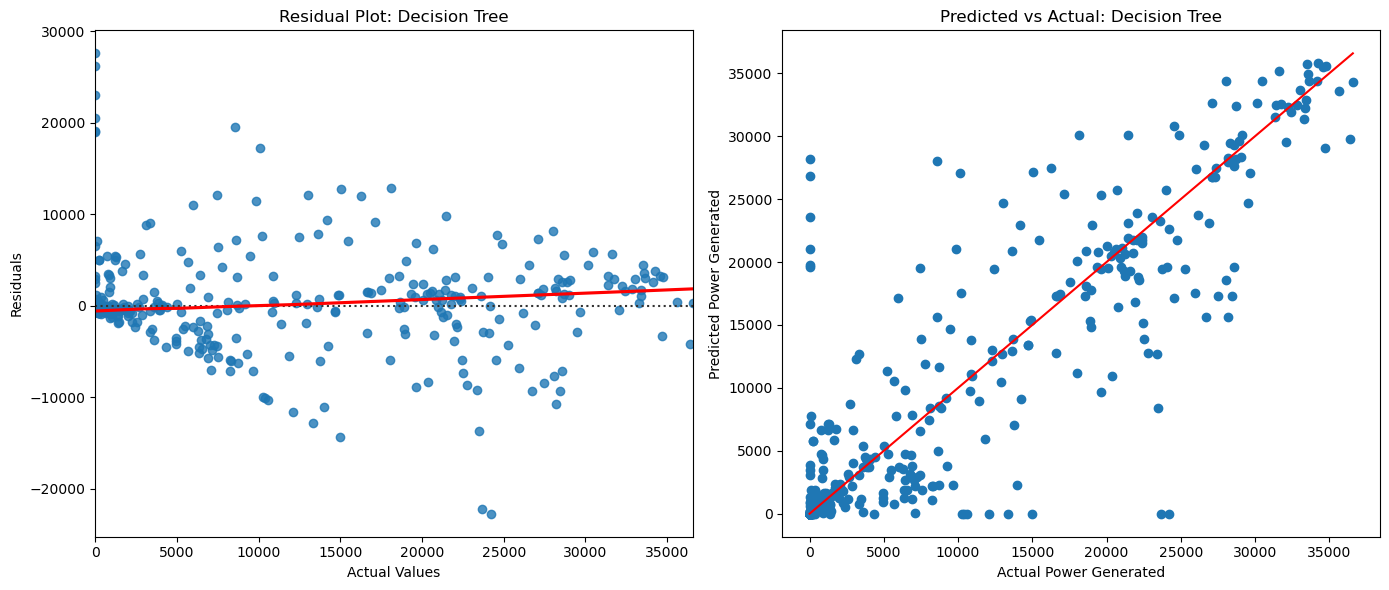

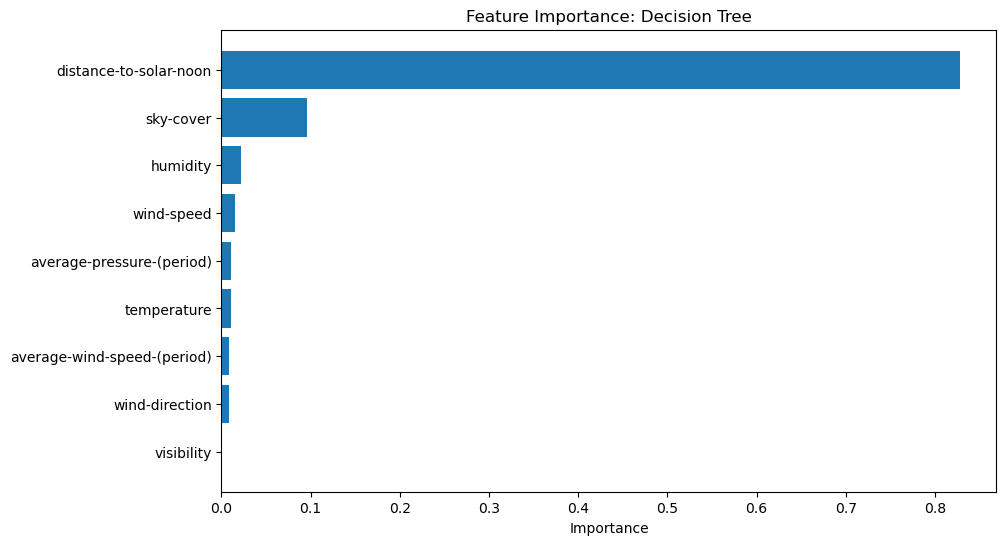

Random Forest:
R²: 0.8898
RMSE: 3407.4542



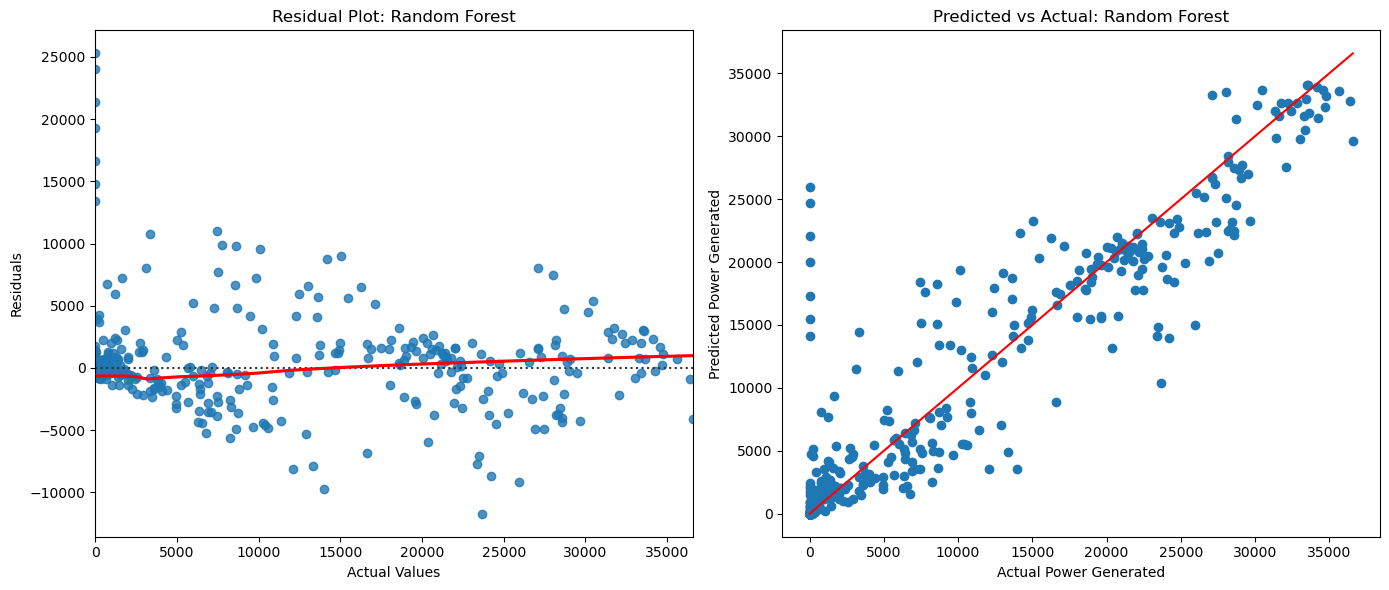

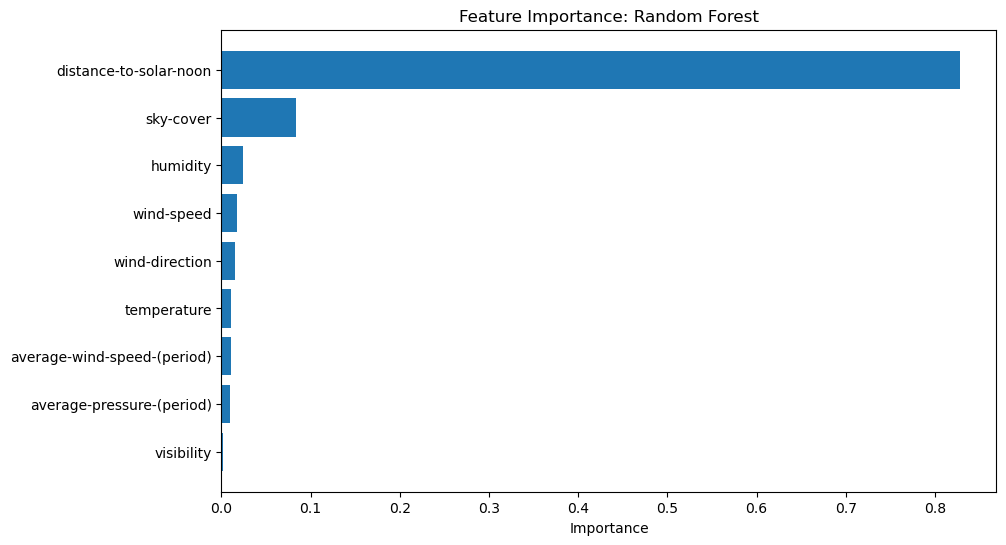

AdaBoost Regression:
R²: 0.8432
RMSE: 4064.6903



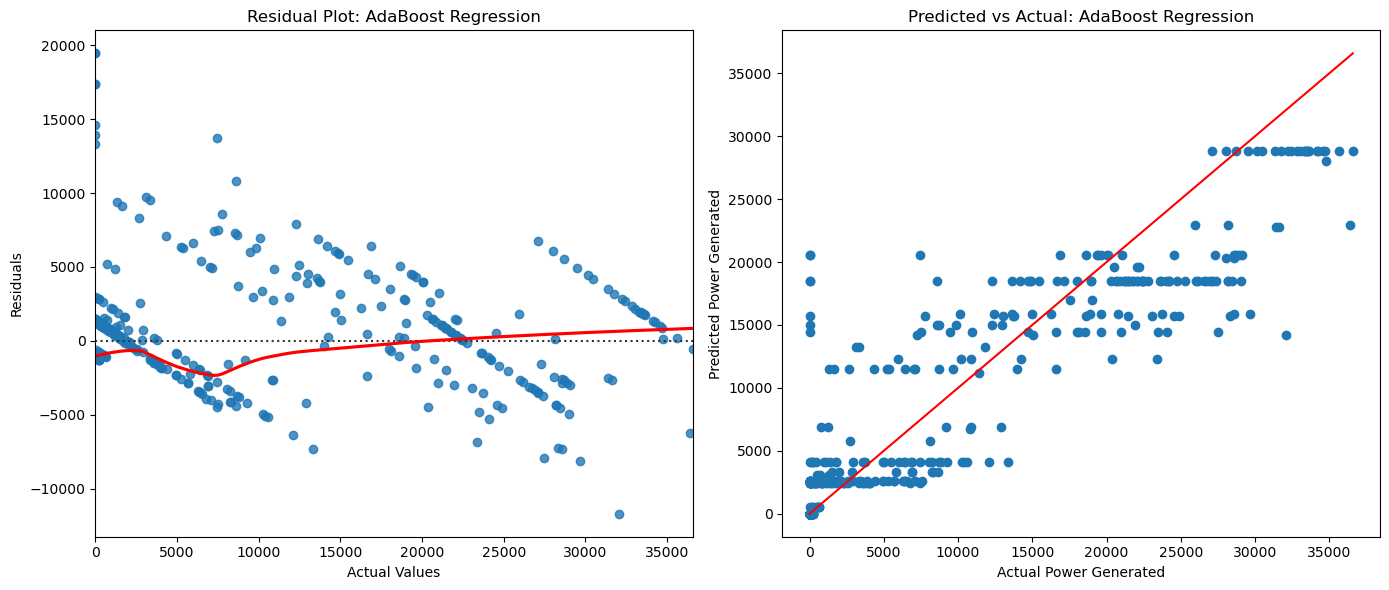

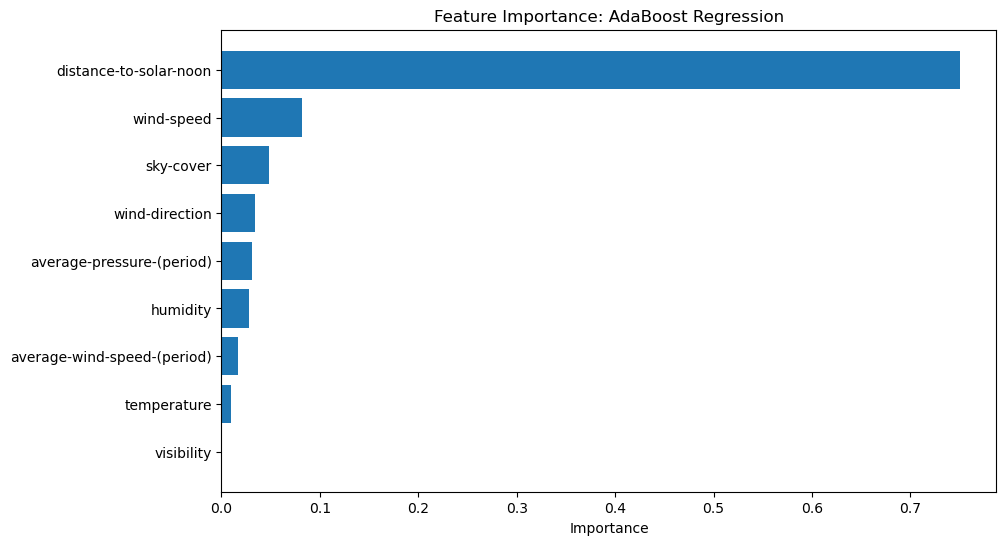

XGBoost Regression:
R²: 0.9010
RMSE: 3229.5700



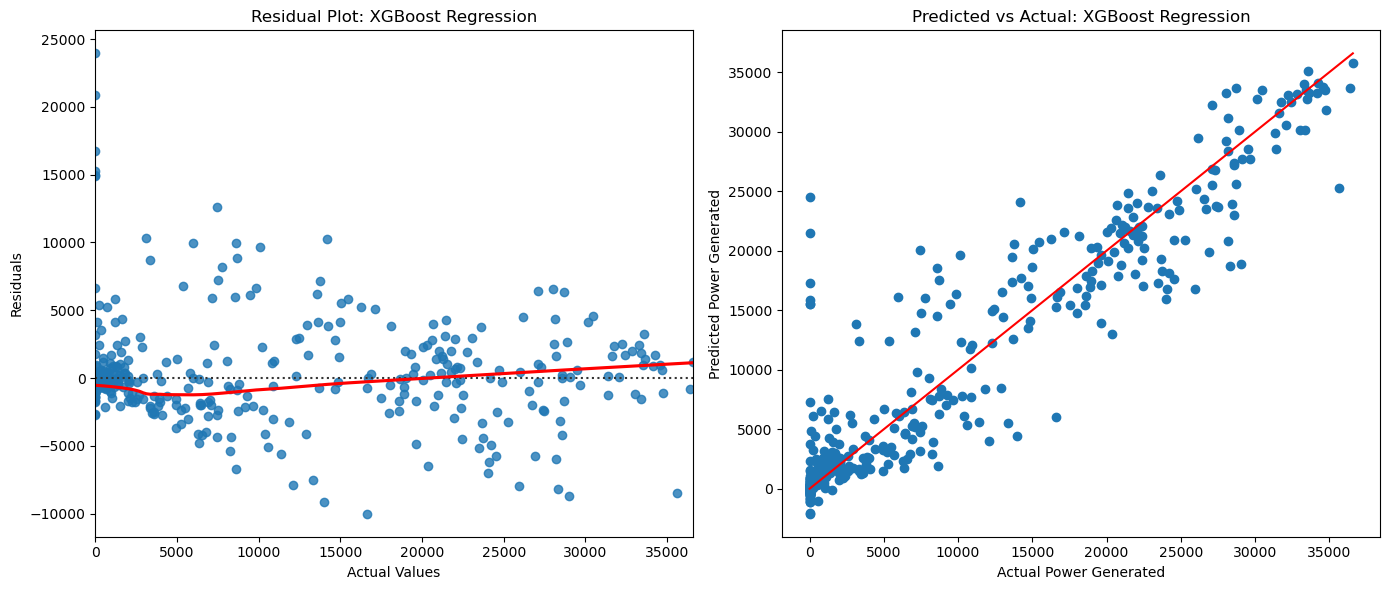

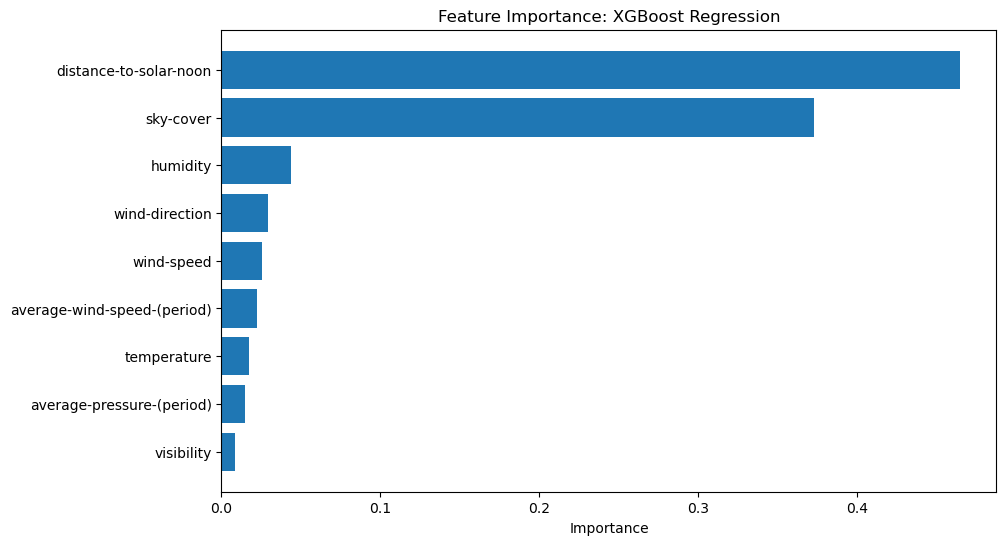

In [43]:
# Initialize models
#Various regression models are initialized, including both linear models with regularization (Lasso and Ridge), 
#ensemble methods (Random Forest, AdaBoost, XGBoost), and a support vector machine.

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(random_state=42),
    'Ridge Regression': Ridge(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
   
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f'{name}:')
    print(f'R²: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}\n')
    
    # Plot Residuals
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.residplot(x=y_test, y=y_pred, lowess=True, line_kws={'color': 'red'})
    plt.title(f'Residual Plot: {name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    
    # Plot Predicted vs Actual
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # 45-degree line
    plt.title(f'Predicted vs Actual: {name}')
    plt.xlabel('Actual Power Generated')
    plt.ylabel('Predicted Power Generated')
    
    plt.tight_layout()
    plt.show()
    
    # Feature Importance Plot for Tree-based models
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(data.columns.drop('power-generated'))[sorted_idx])
        plt.title(f'Feature Importance: {name}')
        plt.xlabel('Importance')
        plt.show()

